<a href="https://colab.research.google.com/github/IleanaGenevieveBarbier/sudoku_solver_cv/blob/main/Barbier_SudokuSolver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:

import os
import cv2
import numpy as np
import imutils
from imutils.perspective import four_point_transform
from skimage.segmentation import clear_border
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
from google.colab import files

def solve_sudoku(board):
    empty = find_empty(board)
    if not empty:
        return True
    row, col = empty

    for num in range(1, 10):
        if is_valid(board, num, (row, col)):
            board[row][col] = num

            if solve_sudoku(board):
                return True

            board[row][col] = 0

    return False

def is_valid(board, num, pos):
    for i in range(len(board[0])):
        if board[pos[0]][i] == num and pos[1] != i:
            return False

    for i in range(len(board)):
        if board[i][pos[1]] == num and pos[0] != i:
            return False

    box_x = pos[1] // 3
    box_y = pos[0] // 3

    for i in range(box_y*3, box_y*3 + 3):
        for j in range(box_x*3, box_x*3 + 3):
            if board[i][j] == num and (i, j) != pos:
                return False

    return True

def find_empty(board):
    for i in range(len(board)):
        for j in range(len(board[0])):
            if board[i][j] == 0:
                return (i, j)
    return None

class SudokuNet:
    @staticmethod
    def build(width, height, depth, classes):
        model = Sequential()
        inputShape = (height, width, depth)
        model.add(Conv2D(32, (5, 5), padding="same", input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Conv2D(32, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Flatten())
        model.add(Dense(64))
        model.add(Activation("relu"))
        model.add(Dropout(0.5))
        model.add(Dense(classes))
        model.add(Activation("softmax"))
        return model

def find_puzzle(image, debug=False):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (7, 7), 3)
    thresh = cv2.adaptiveThreshold(blurred, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    thresh = cv2.bitwise_not(thresh)

    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

    puzzleCnt = None
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        if len(approx) == 4:
            puzzleCnt = approx
            break

    if puzzleCnt is None:
        raise Exception("Impossible de trouver la grille de Sudoku dans l'image")

    puzzle = four_point_transform(image, puzzleCnt.reshape(4, 2))
    warped = four_point_transform(gray, puzzleCnt.reshape(4, 2))
    return (puzzle, warped)

def extract_digit(cell, debug=False):
    thresh = cv2.threshold(cell, 0, 255,
        cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    thresh = clear_border(thresh)

    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    if len(cnts) == 0: return None

    c = max(cnts, key=cv2.contourArea)
    mask = np.zeros(thresh.shape, dtype="uint8")
    cv2.drawContours(mask, [c], -1, 255, -1)

    (h, w) = thresh.shape
    percentFilled = cv2.countNonZero(mask) / float(w * h)

    if percentFilled < 0.03: return None

    digit = cv2.bitwise_and(thresh, thresh, mask=mask)
    return digit


print("Chargement de MNIST...")
((trainData, trainLabels), (testData, testLabels)) = mnist.load_data()

trainData = trainData.reshape((trainData.shape[0], 28, 28, 1))
testData = testData.reshape((testData.shape[0], 28, 28, 1))
trainData = trainData.astype("float32") / 255.0
testData = testData.astype("float32") / 255.0

print("Compilation du modele...")
opt = Adam(learning_rate=1e-3)
model = SudokuNet.build(width=28, height=28, depth=1, classes=10)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

print("Entrainement du classifieur de chiffres...")
model.fit(trainData, trainLabels, validation_data=(testData, testLabels),
    batch_size=64, epochs=2, verbose=1)


Chargement de MNIST...
Compilation du modele...
Entrainement du classifieur de chiffres...
Epoch 1/2
938/938 ━━━━━━━━━━━━━━━━━━━━ 70s 73ms/step - accuracy: 0.7945 - loss: 0.6350 - val_accuracy: 0.9784 - val_loss: 0.0665
Epoch 2/2
938/938 ━━━━━━━━━━━━━━━━━━━━ 67s 71ms/step - accuracy: 0.9575 - loss: 0.1405 - val_accuracy: 0.9860 - val_loss: 0.0447


Upload ton image de Sudoku 


Saving Sudoku-by-L2G-20050714.svg.png to Sudoku-by-L2G-20050714.svg (5).png
Traitement de Sudoku-by-L2G-20050714.svg (5).png...
Extraction des chiffres et OCR...
Grille detectee par OCR :
[[5 3 0 0 7 0 0 0 0]
 [6 0 0 1 9 5 0 0 0]
 [0 9 8 0 0 0 0 6 0]
 [8 0 0 0 6 0 0 0 3]
 [4 0 0 8 0 3 0 0 1]
 [7 0 0 0 2 0 0 0 6]
 [0 6 0 0 0 0 2 8 0]
 [0 0 0 4 1 9 0 0 5]
 [0 0 0 0 8 0 0 7 9]]
Resolution...
Sudoku résolu


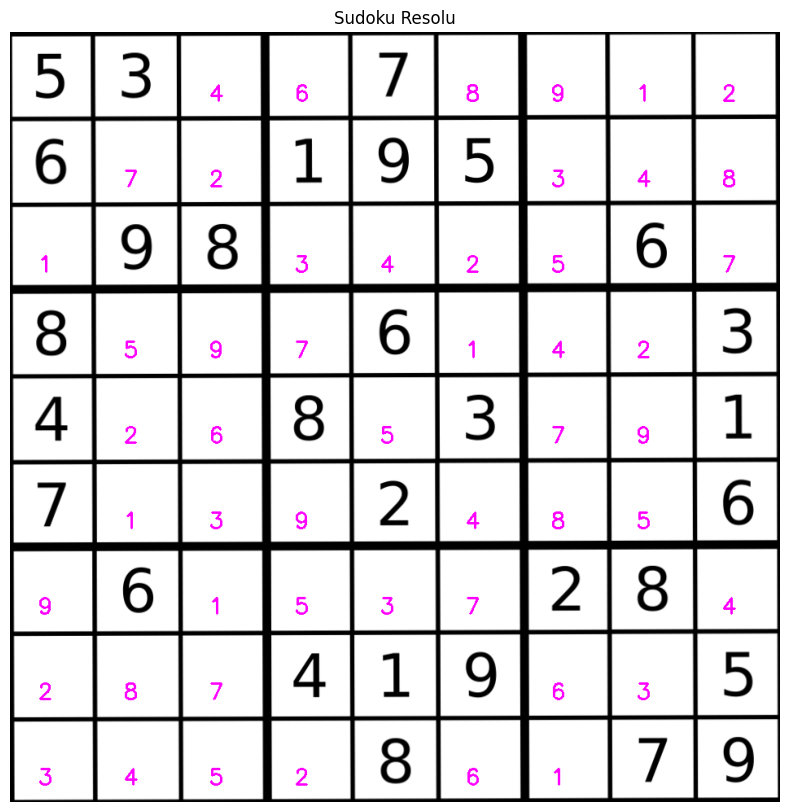

In [14]:


print("Upload ton image de Sudoku ")
uploaded = files.upload()

if not uploaded:
    print("Pas de fichier. Telechargement d'un exemple...")
    !wget -O sudoku_sample.jpg https://pyimagesearch.com/wp-content/uploads/2020/08/sudoku_puzzle.jpg
    image_path = "sudoku_sample.jpg"
else:
    image_path = list(uploaded.keys())[0]

print(f"Traitement de {image_path}...")
image = cv2.imread(image_path)
(puzzleImage, warped) = find_puzzle(image)

board = np.zeros((9, 9), dtype="int")
stepX = warped.shape[1] // 9
stepY = warped.shape[0] // 9
cell_locs = []

print("Extraction des chiffres et OCR...")
for y in range(0, 9):
    row = []
    for x in range(0, 9):
        startX = x * stepX
        startY = y * stepY
        endX = (x + 1) * stepX
        endY = (y + 1) * stepY

        if startX < endX and startY < endY:
            cell = warped[startY:endY, startX:endX]
            digit = extract_digit(cell)

            if digit is not None:
                roi = cv2.resize(digit, (28, 28))
                roi = roi.astype("float") / 255.0
                roi = img_to_array(roi)
                roi = np.expand_dims(roi, axis=0)
                pred = model.predict(roi, verbose=0).argmax(axis=1)[0]
                board[y, x] = pred

            row.append((startX, startY, endX, endY))
    cell_locs.append(row)

print("Grille detectee par OCR :")
print(board)

print("Resolution...")
board_solution = board.copy()
solved = solve_sudoku(board_solution)

if solved:
    print("Sudoku résolu")
    for y in range(9):
        for x in range(9):
            if board[y][x] == 0:
                startX, startY, endX, endY = cell_locs[y][x]
                testX = int((endX - startX) * 0.33)
                testY = int((endY - startY) * -0.2)
                testX += startX
                testY += endY

                cv2.putText(puzzleImage, str(board_solution[y][x]), (testX, testY),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 255), 2)

    plt.figure(figsize=(10,10))
    plt.imshow(cv2.cvtColor(puzzleImage, cv2.COLOR_BGR2RGB))
    plt.title("Sudoku Resolu")
    plt.axis('off')
    plt.show()
else:
    print("Impossible de resoudre la grille")